**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import string
import re
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN
from tensorflow.keras.callbacks import ReduceLROnPlateau

**Data Pre-processing**

In [2]:
# Load Dataset
df = pd.read_csv("imdb_movie_reviews.csv")
print(df.isnull().sum())
print(df.info())
print(df['sentiment'].unique())

review       0
sentiment    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
['positive' 'negative']


**Lable Encoding**

In [3]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

**Data Visualization**

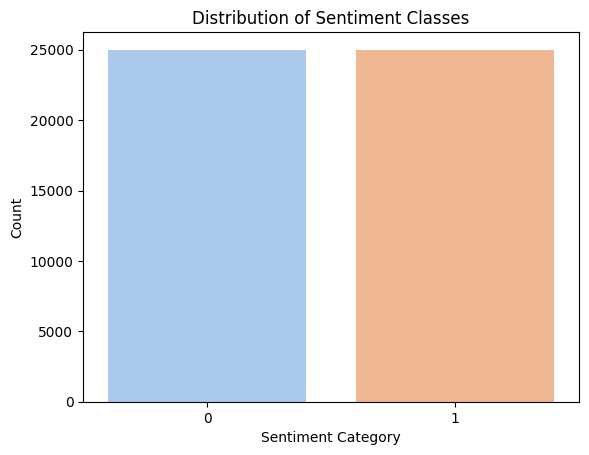

,count
sentiment,
1,50.0
0,50.0


In [4]:
sns.countplot(data= df, x='sentiment',hue='sentiment',palette='pastel',legend=False)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Display percentage distribution of sentiment values
(df['sentiment'].value_counts() / len(df) * 100).round(2)


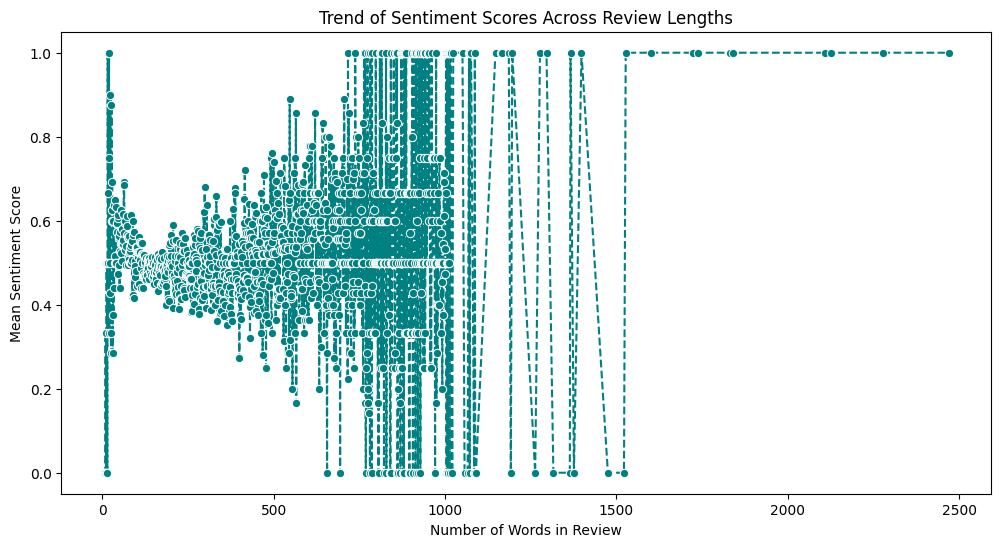

In [5]:
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

# Calculate the average sentiment for each word count group
sentiment_by_length = df.groupby('word_count')['sentiment'].agg('mean')

# Create a figure with a specified size
plt.figure(figsize=(12, 6))

# Plot the data using Seaborn's lineplot
sns.lineplot(data=sentiment_by_length, marker='o', linestyle='dashed', color='teal')

# Customize plot labels and title
plt.title('Trend of Sentiment Scores Across Review Lengths')
plt.xlabel('Number of Words in Review')
plt.ylabel('Mean Sentiment Score')

# Show the plot
plt.show()


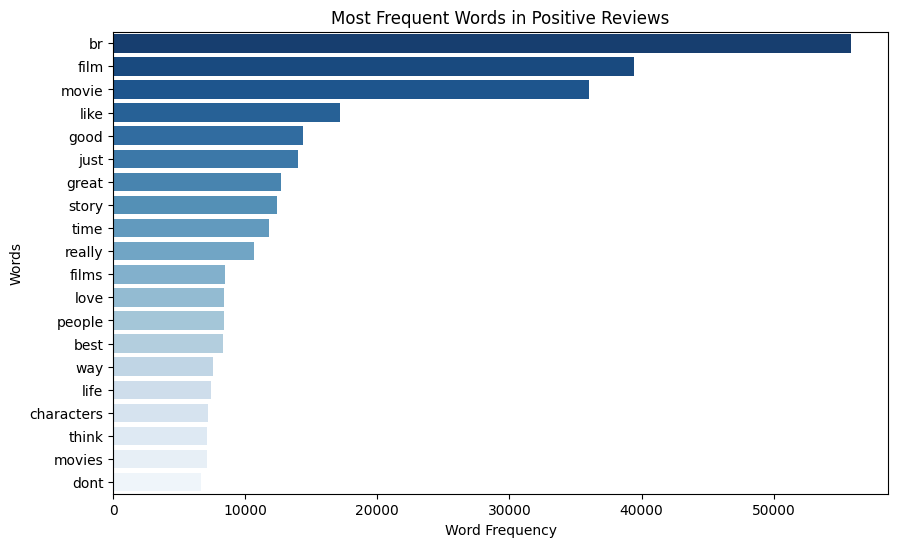

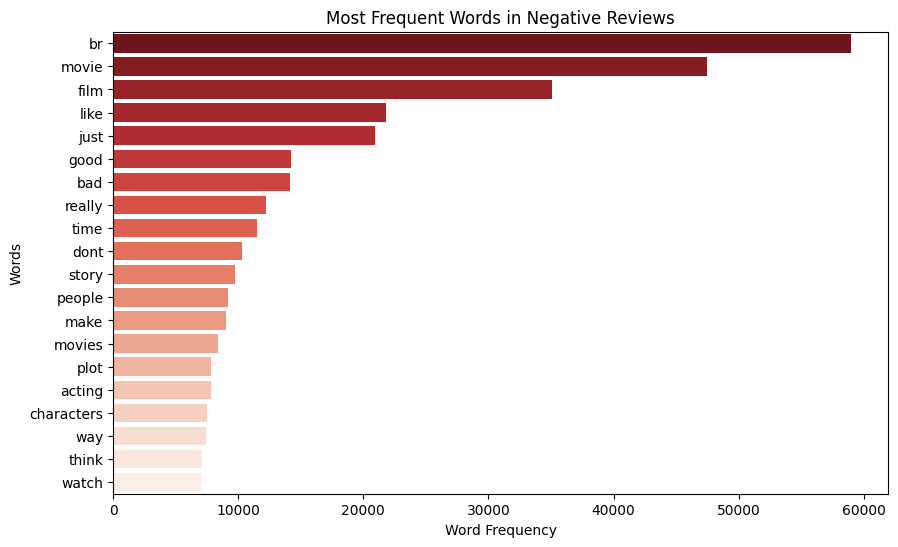

In [6]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return words

# Extract words for each sentiment
pos_words = preprocess_text(' '.join(df.loc[df['sentiment'] == 1, 'review']))
neg_words = preprocess_text(' '.join(df.loc[df['sentiment'] == 0, 'review']))

# Compute word frequencies
pos_word_count = Counter(pos_words)
neg_word_count = Counter(neg_words)

# Find top 20 most frequent words
top_pos_words = pos_word_count.most_common(20)
top_neg_words = neg_word_count.most_common(20)

# Convert to DataFrame for Seaborn
import pandas as pd
pos_df = pd.DataFrame(top_pos_words, columns=['word', 'count'])
neg_df = pd.DataFrame(top_neg_words, columns=['word', 'count'])

# Plotting Positive Words
plt.figure(figsize=(10, 6))
sns.barplot(data=pos_df, x='count', y='word', hue='word', palette='Blues_r', dodge=False, legend=False)  # Fix applied
plt.title('Most Frequent Words in Positive Reviews')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.show()

# Plotting Negative Words
plt.figure(figsize=(10, 6))
sns.barplot(data=neg_df, x='count', y='word', hue='word', palette='Reds_r', dodge=False, legend=False)  # Fix applied
plt.title('Most Frequent Words in Negative Reviews')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.show()


In [7]:
df['cleaned_review'] = df['review'].apply(lambda x: ' '.join(preprocess_text(x)))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42)

In [8]:
# Model 1: Random Forest (TF-IDF) ---
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8461
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


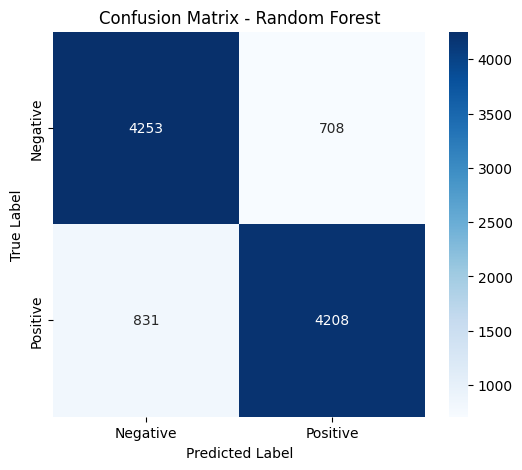

In [10]:
# Example for Random Forest
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

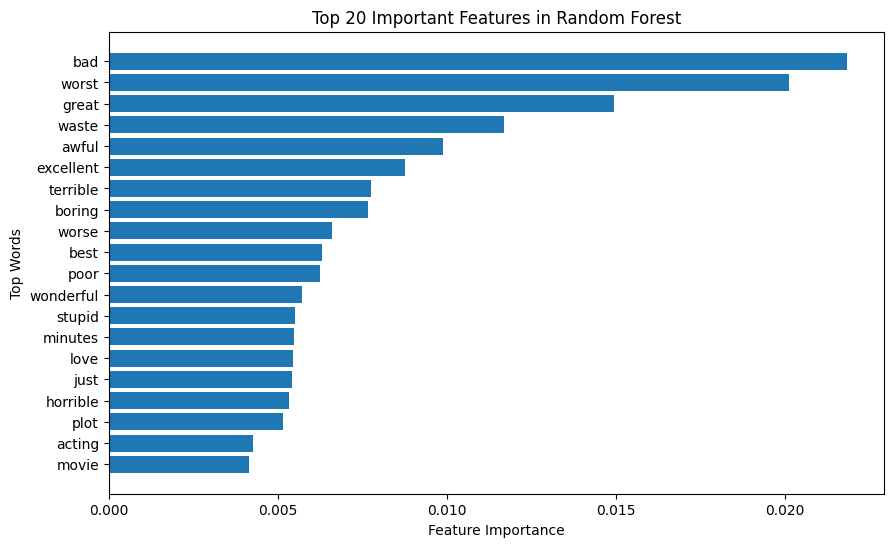

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the trained model
feature_importances = rf_model.feature_importances_

# Get feature names from the TfidfVectorizer
feature_names = vectorizer.get_feature_names_out()

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[-20:]  # Top 20 features

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(20), feature_importances[sorted_indices], align="center")
plt.yticks(range(20), [feature_names[i] for i in sorted_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Top Words")
plt.title("Top 20 Important Features in Random Forest")
plt.show()


In [12]:
# Tokenization
max_words = 20000
max_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

vocab_size = min(len(tokenizer.word_index) + 1, max_words)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to ensure uniform length
X_train_seq = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [13]:
# Load Pre-trained GloVe Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding_index[word] = np.array(values[1:], dtype="float32")

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)

--2025-03-08 15:12:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-08 15:12:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-08 15:12:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
from sklearn.metrics import accuracy_score

# --- Model 2: LSTM with GloVe Embeddings ---
lstm_model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Store history from fit()
history_lstm = lstm_model.fit(
    X_train_seq, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_seq, y_test),
    callbacks=[lr_scheduler]
)

# Print available keys in history to confirm it worked
print("History Keys:", history_lstm.history.keys())

# Evaluate LSTM Model
y_pred_lstm_prob = lstm_model.predict(X_test_seq)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int).flatten()
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("LSTM Accuracy:", accuracy_lstm)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 179s 278ms/step - accuracy: 0.7033 - loss: 0.5654 - val_accuracy: 0.8209 - val_loss: 0.4142 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 258ms/step - accuracy: 0.8223 - loss: 0.4086 - val_accuracy: 0.8353 - val_loss: 0.3758 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 209s 268ms/step - accuracy: 0.8535 - loss: 0.3480 - val_accuracy: 0.8459 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 169s 270ms/step - accuracy: 0.8629 - loss: 0.3265 - val_accuracy: 0.8586 - val_loss: 0.3352 - learning_rate: 0.0010
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 169s 270ms/step - accuracy: 0.8737 - loss: 0.3034 - val_accuracy: 0.8618 - val_loss: 0.3363 - learning_rate: 0.0010
History Keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step
LSTM Accuracy: 0.8618


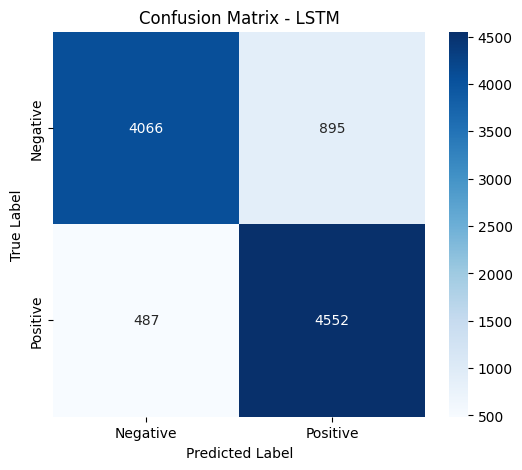

In [15]:
plot_confusion_matrix(y_test, y_pred_lstm, "LSTM")

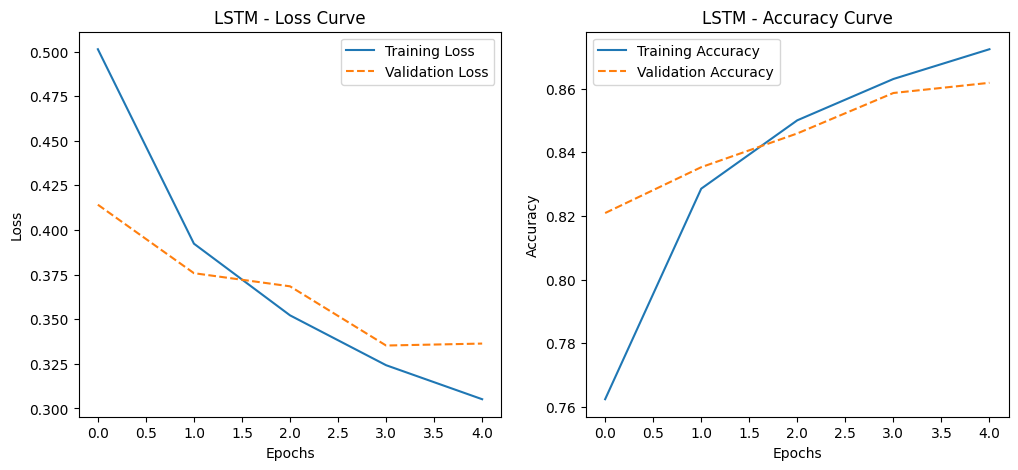

In [16]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, model_name):
    keys = history.keys()

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.legend()

    plt.show()

# Plot LSTM Learning Curves
plot_learning_curves(history_lstm.history, "LSTM")


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D

# --- CNN Model ---
cnn_model = Sequential([
    embedding_layer,
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),  # Add dropout here to reduce overfitting
    Dense(1, activation='sigmoid')
])


cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN Model
history_cnn = cnn_model.fit(
    X_train_seq, y_train,
    epochs=6,
    batch_size=128,
    validation_data=(X_test_seq, y_test)
)

# Evaluate CNN Model
y_pred_cnn_prob = cnn_model.predict(X_test_seq)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print("CNN Accuracy:", accuracy_cnn)

Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.6603 - loss: 0.6424 - val_accuracy: 0.8152 - val_loss: 0.4154
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.8081 - loss: 0.4192 - val_accuracy: 0.8206 - val_loss: 0.3988
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.8316 - loss: 0.3796 - val_accuracy: 0.8399 - val_loss: 0.3672
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.8456 - loss: 0.3539 - val_accuracy: 0.8398 - val_loss: 0.3680
Epoch 5/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8548 - loss: 0.3349 - val_accuracy: 0.8437 - val_loss: 0.3604
Epoch 6/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - accuracy: 0.8625 - loss: 0.3177 - val_accuracy: 0.8437 - val_loss: 0.3580
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
CNN Accuracy: 0.8437


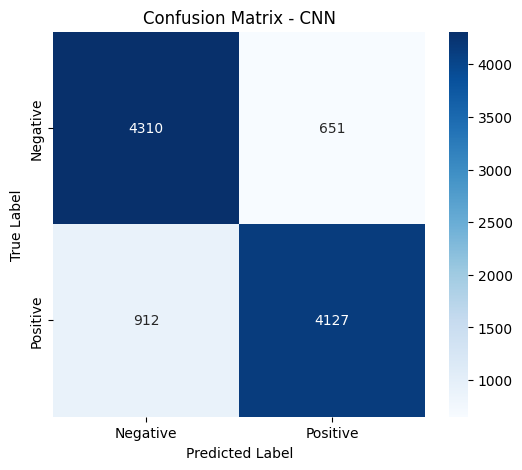

In [18]:
plot_confusion_matrix(y_test, y_pred_cnn, "CNN")

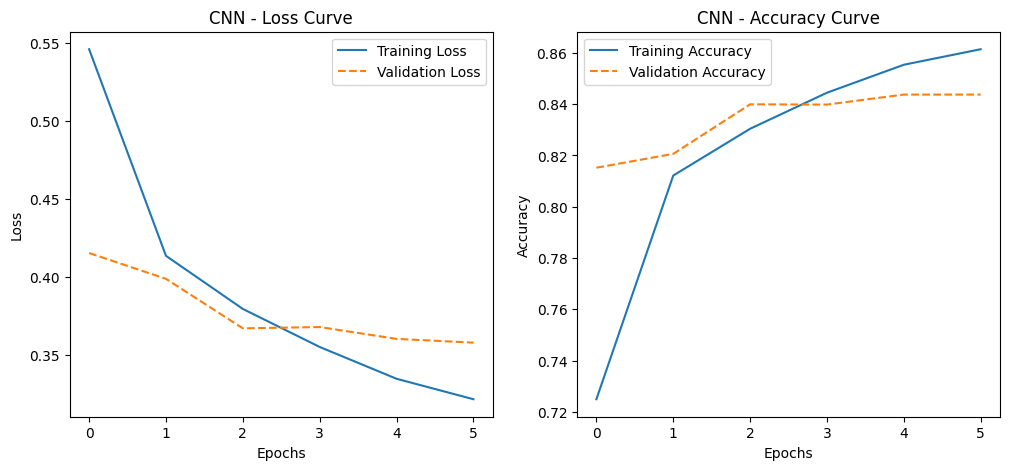

In [19]:
# Plot CNN Learning Curves
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.legend()

    plt.show()

plot_learning_curves(history_cnn, "CNN")

<ipython-input-21-695a2460c0a0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette="coolwarm")


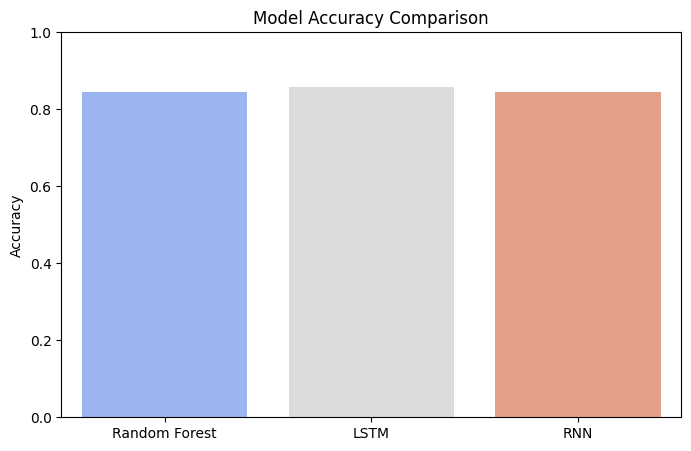

In [ ]:
import numpy as np

# Assuming you have already calculated accuracy scores
accuracy_scores = {
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "LSTM": accuracy_score(y_test, y_pred_lstm),
    "RNN": accuracy_score(y_test, y_pred_cnn)
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette="coolwarm")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Accuracy range is 0 to 1
plt.show()
